# Simple Autoencoder

# 1. Imports

In [1]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# create datasets using `ImageFolder`
from torchvision.datasets import ImageFolder
# import compose and other transformations
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop
# plotting
import matplotlib.pyplot as plt


# for file paths
import os
# for time
import time
# for copying
import copy

In [2]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

True
True


In [3]:
# training on GPU
device

device(type='mps')

# 2 Preparing Data

In [4]:
# model hyper-parameters
input_size = 28*28
hidden_size = 50
latent_space_size = 20

# other hyper-parameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001

In [5]:
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# we want the pixel values in each individual channel to have a value between 0 and 1, with a mean of 0.5 and std dev of 0.25.
mean = np.array([0.5])
std = np.array([0.25])

transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

# train
# keep download=True, the first time
'''
train_dataset = MNIST(
    root='./data/MNIST/',
    train=True,
    transform=transform,
    download=True
)
'''
train_dataset = MNIST(
    root='./data/MNIST/',
    train=True,
    transform=transform
)

# test
test_dataset = MNIST(
    root='./data/MNIST/',
    train=False,
    transform=transform
    # don't have to download again
)

# DataLoader
image_dataloaders = {
    'train' : DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    ),
    'test' : DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
}

# extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))
print("Test Shapes:", X_test.shape, y_test.shape)
# reshaping the data
X_test = X_test.reshape(-1, 28*28)
# adding to GPU
X_test, y_test = X_test.to(device), y_test.to(device)

# printing info
print("Size of Train Dataset:", len(train_dataset))
print("Size of Test Dataset:", len(test_dataset))

print("Test Shapes:", X_test.shape, y_test.shape)


Test Shapes: torch.Size([128, 1, 28, 28]) torch.Size([128])
Size of Train Dataset: 60000
Size of Test Dataset: 10000
Test Shapes: torch.Size([128, 784]) torch.Size([128])


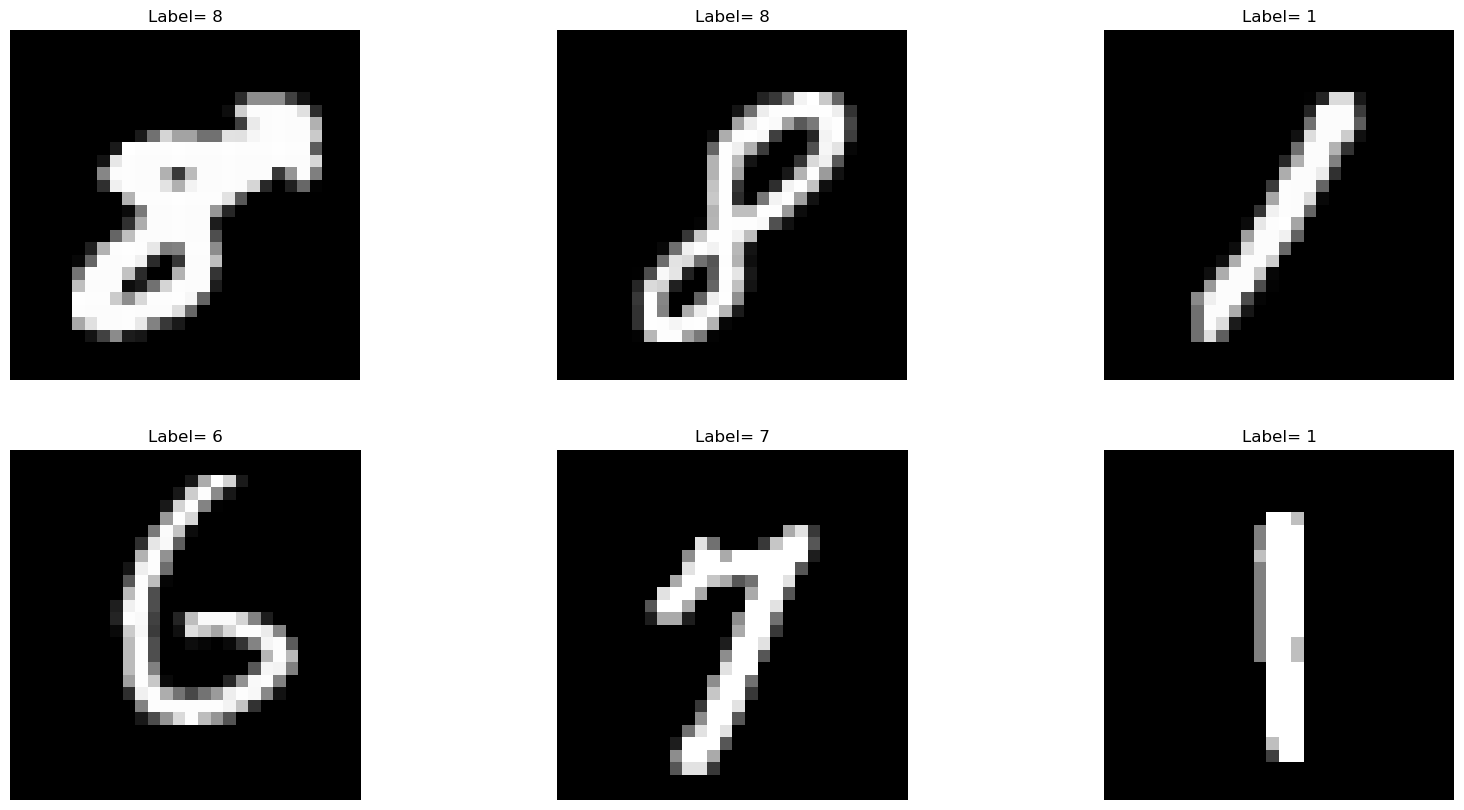

In [6]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Label= " + str(y_test[i].item()))
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Model

In [7]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=50, code_size=10):
        # code size: dim of latent space
        super(SimpleAutoencoder, self).__init__()
        
        # extracting parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.code_size = code_size

        # encoder
        self.encoder = nn.Sequential(
            # layer-1
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            # layer-2
            nn.Linear(hidden_size, code_size),
            nn.Tanh()
        )

        # decoder
        self.decoder = nn.Sequential(
            # layer-1
            nn.Linear(code_size, hidden_size),
            nn.ReLU(),
            # layer-2
            nn.Linear(hidden_size, input_size),
            nn.Tanh()
        )
    
    def forward(self, X):
        # encoding
        z = self.encoder(X)
        # decoding
        X_hat = self.decoder(z)

        return X_hat, z
    
    def generate(self, n_samples = 4):
        # generate 'n_samples' no. of random vector of size = `code_size` (in the latent space) 
        # ~ note: the input pixels to the decoder should be between -1,1 because the activation function is tanh 
        # ~ note: the input pixels to to the decoder should be between 0,1, if the activation before is sigmoid
        z = torch.randn((n_samples, self.code_size)).to(device)
        z = 2*z - 1
        # generate the images via decoder
        with torch.no_grad():
            gen_images = self.decoder(z)
        return gen_images

Let's initialize the model and test the results on the test dataset.

In [8]:
# print the model parameters
print(input_size, hidden_size, latent_space_size)

784 50 10


In [9]:
# define the model
model = SimpleAutoencoder(
    input_size=input_size,
    hidden_size=hidden_size,
    code_size=latent_space_size
).to(device=device)

In [10]:
# we also check the initial reconstruction mse on the test data before training

from sklearn.metrics import mean_squared_error

with torch.no_grad():
    X_test_hat, _ = model(X_test)
    # push the matrices back to cpu from gpu
    X_test_cpu, X_test_hat_cpu = X_test.cpu(), X_test_hat.cpu()
    print("Initial Reconstruction MSE on test data:", mean_squared_error(X_test_cpu, X_test_hat_cpu))

Initial Reconstruction MSE on test data: 3.7028909


Initial generation by the Autoencoder via randomly sampled points from the latent space.

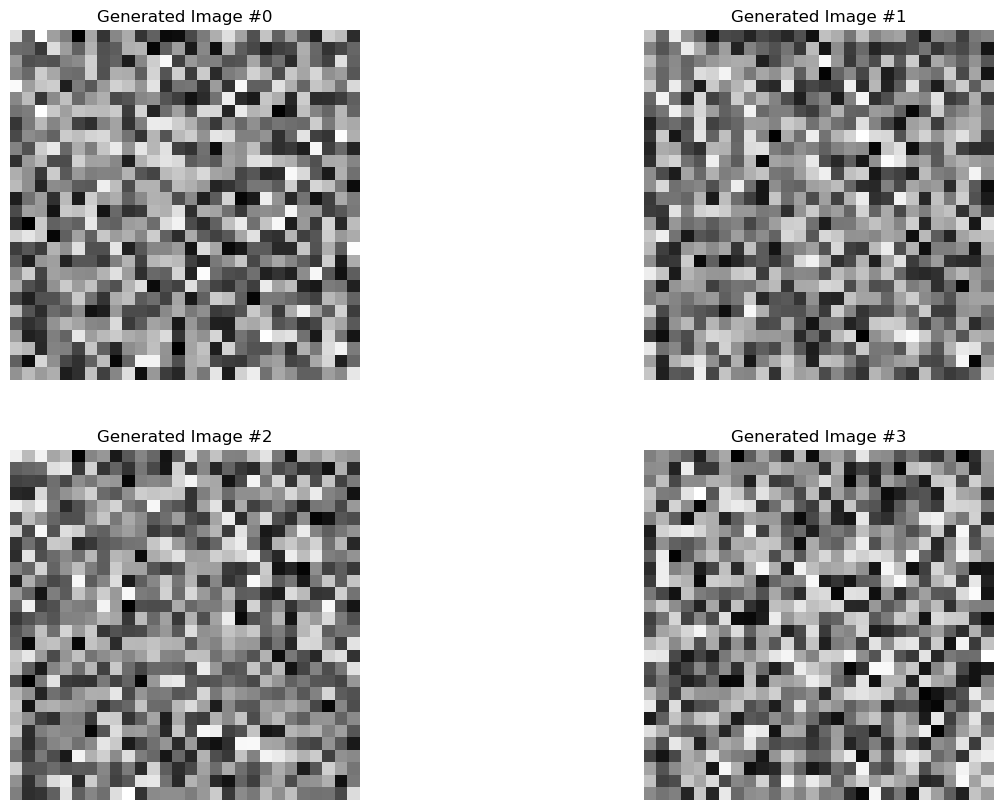

In [11]:
# no. of images to generate
n_samples = 4

with torch.no_grad():
    generated_images = model.generate(n_samples)

plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    # copy the image back to cpu to reshape
    img = generated_images[i].cpu()
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Generated Image #" + str(i))
    plt.grid(False)
    plt.axis(False)
plt.show()

# 4. Training

In [12]:
from sklearn.metrics import mean_squared_error

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20):
    # begin start time to record time-elapsed
    # since = time.time()

    # to return the model with best accuracy
    # variable to store the best model parameters
    best_model_params = copy.deepcopy(model.state_dict())
    # variable to store the best loss
    best_loss = np.Inf

    # start training epochs
    for epoch in range(num_epochs):

        # each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase=='train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            # iterate over data
            for batch in image_dataloaders[phase]:
                # extract features and labels
                X,y = batch
                # reshape data
                X = X.reshape(-1, 28*28)
                # adding to GPU
                X,y = X.to(device), y.to(device)

                # forward
                # track grad iff phase == train
                with torch.set_grad_enabled(phase=='train'):
                    # compute prediction
                    X_hat, _ = model(X)

                    # loss + backward + optimize iff phase = 'train'
                    if phase=='train':
                        # compute loss
                        loss = criterion(X_hat, X)
                        # compute grads
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # zero-gradients after updating
                        optimizer.zero_grad()
                
            # learning scheduler step iff phase == 'train'
            if scheduler and phase=='train':
                # update learning rate
                scheduler.step()
            
            # check accuracy on validation set iff phase == 'test'
            if phase=='test':
                epoch_loss = mean_squared_error(X.cpu(), X_hat.cpu())

        # update best_model and best accuracy after the epoch
        if epoch_loss <= best_loss:
            best_loss = epoch_loss
            best_model_params = copy.deepcopy(model.state_dict())
        
        # print epoch info
        print('-----------------------------------------')
        print('Epoch: {}/{}'.format(epoch+1, num_epochs))
        print('Best Test Loss: {:2f}'.format(best_loss))
        # to keep track of time
        '''
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        '''
    

    # post training, load the best_model parameters and output the model

    # load best model weights
    model.load_state_dict(best_model_params)
    return model


In [13]:
# define parameters for training

# add model to GPU
model = model.to(device)

# define loss
criterion = nn.MSELoss()

# define optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = learning_rate
)

In [14]:
model = train_model(
    model=model,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer
)

-----------------------------------------
Epoch: 1/10
Best Test Loss: 1.526688
-----------------------------------------
Epoch: 2/10
Best Test Loss: 1.302962
-----------------------------------------
Epoch: 3/10
Best Test Loss: 1.302962
-----------------------------------------
Epoch: 4/10
Best Test Loss: 1.244410
-----------------------------------------
Epoch: 5/10
Best Test Loss: 1.244410
-----------------------------------------
Epoch: 6/10
Best Test Loss: 1.228405
-----------------------------------------
Epoch: 7/10
Best Test Loss: 1.210117
-----------------------------------------
Epoch: 8/10
Best Test Loss: 1.201293
-----------------------------------------
Epoch: 9/10
Best Test Loss: 1.184970
-----------------------------------------
Epoch: 10/10
Best Test Loss: 1.184970


Saving and Loading the model.

In [20]:
save_path = os.path.join('models','SAE.pth')
save_path

'models/SAE.pth'

In [21]:
# saving the model
torch.save(model.state_dict(), save_path)

In [22]:
# loading the model

# define the model
model = SimpleAutoencoder(
    input_size=input_size,
    hidden_size=hidden_size,
    code_size=latent_space_size
).to(device=device)

model.load_state_dict(torch.load(save_path))
model.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=784, bias=True)
    (3): Tanh()
  )
)

# 5. Evaluation

In [23]:
# we also check the final reconstruction mse on the test data after training

from sklearn.metrics import mean_squared_error

with torch.no_grad():
    X_test_hat, _ = model(X_test)
    # push the matrices back to cpu from gpu
    X_test_cpu, X_test_hat_cpu = X_test.cpu(), X_test_hat.cpu()
    print("Final Reconstruction MSE on test data:", mean_squared_error(X_test_cpu, X_test_hat_cpu))

Final Reconstruction MSE on test data: 1.2016975


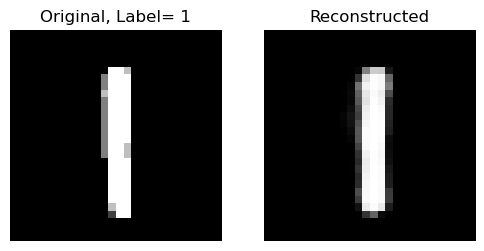

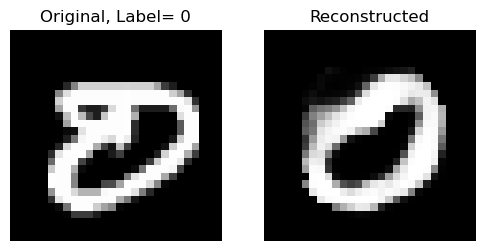

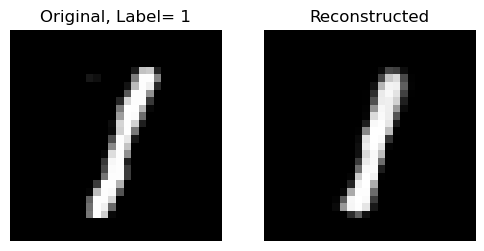

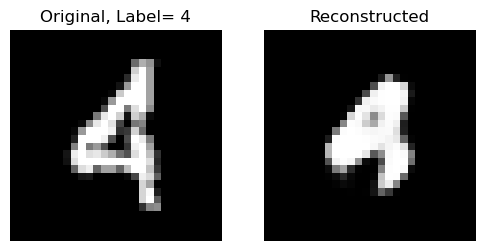

In [24]:
# no. of examples to print
n_examples = 4
test_idx = np.random.randint(X_test.shape[0] ,size=n_examples)

for idx in test_idx:
    X = X_test[idx]
    with torch.no_grad():
        X_hat, _ = model(X)
    
    # copying image, re-constructed image back to cpu
    img, rec_img = X.cpu(), X_hat.cpu()

    plt.figure(figsize=(6,3))
    
    # actual image
    plt.subplot(1, 2, 1)
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Original, Label= " + str(y_test[idx].item()))
    plt.grid(False)
    plt.axis(False)

    # reconstructed image
    plt.subplot(1, 2, 2)
    # we only have a single channel image
    plt.imshow(rec_img.reshape(28,28), cmap='gray')
    plt.title("Reconstructed")
    plt.grid(False)
    plt.axis(False)
    

plt.show()

Final generation by the Autoencoder via randomly sampled points from the latent space.

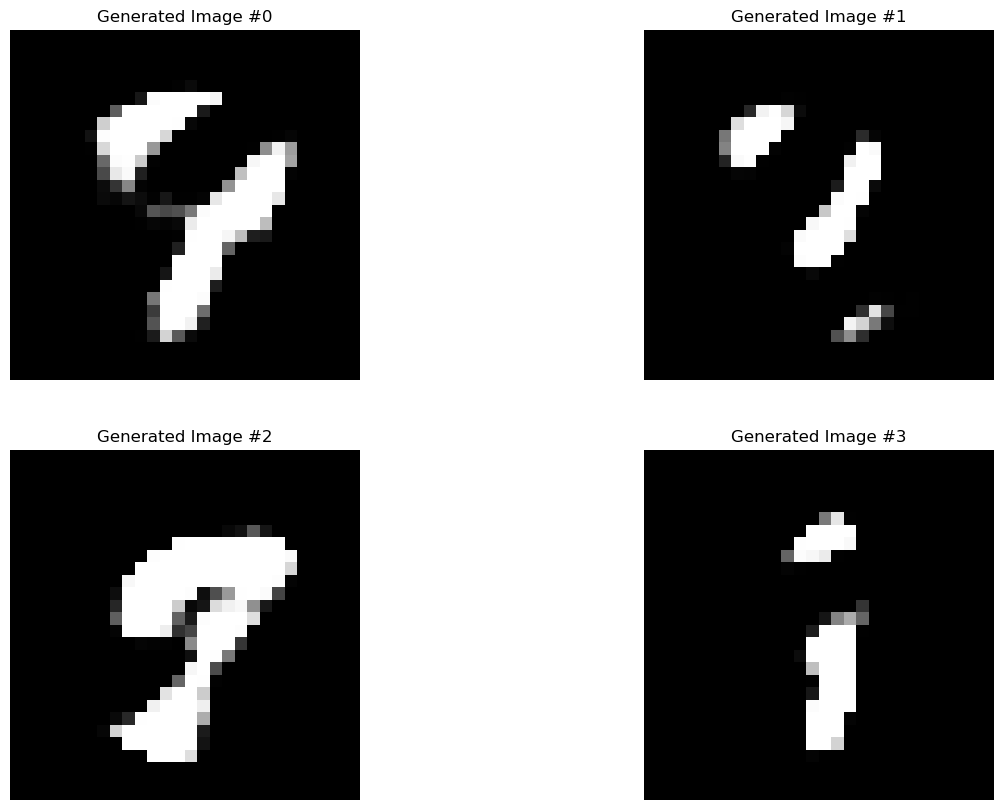

In [25]:
# no. of images to generate
n_samples = 4

with torch.no_grad():
    generated_images = model.generate(n_samples)

plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    # copy the image back to cpu to reshape
    img = generated_images[i].cpu()
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Generated Image #" + str(i))
    plt.grid(False)
    plt.axis(False)
plt.show()

In [ ]:
%%time